# Introduction

This Jupyter Notebook looks at the rates of diagnosis of depression in Birmingham. 

The data sources it uses are:

- [A breakdown of the number of patients in each gp practice by the lsoa they are registered as living in](
https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice/january-2018)

- [Indices of Multiple Deprivation - 2015. Data that gives the Index of Multiple Deprivation rank and decile for Lower Super Output Areas](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015)

- [Quality Outcome Framework data that gives the prevalence rates for the diagnosis of 21 medical conditions by gp practice](https://digital.nhs.uk/data-and-information/publications/statistical/quality-and-outcomes-framework-achievement-prevalence-and-exceptions-data/quality-and-outcomes-framework-qof-2016-17)

- [Ethnicity breakdown at lower super output area level based on data from the 2011 census on the NOMIS website](https://www.nomisweb.co.uk)*

We first built a data model that calculated estimated rates for the diagnosis of conditions at lsoa level.

After generating these estimates a [Tableau visualisation was created](https://public.tableau.com/profile/mikelcu#!/vizhome/BirminghamQOFbyLSOA/Map) which showed that more deprived lsoas in central Birmingham showed a lower diagnosis rate for depression than both more affluent areas and the more deprived areas that we recognised as having a whiter population. Because of this we decided to investigate further what the relative influence of deprivation and ethnicity might be in the diagnosis of depression in Birmingham.

## Notes on factors that may affects the accuracy of this analysis

The NOMIS site includes the following explanatory text
>“In order to protect against disclosure of personal information, records have been swapped between different geographic areas. Some counts will be affected, particularly small counts at the lowest geographies”

this may affect our analysis in ways that we are unable to quantify at the moment.

This notebook is a continuance from the [initial data analysis](http://localhost:8888/notebooks/Google%20Drive/qof/Birmingham_Depression_By_Ethnicity_Aug_2018.ipynb#), which won't be repeated here.   

# Clustering

First, we import the libraries that we are going to be using.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

#visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

#sklearn
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

The following code suppresses the use of scientific float notation in Jupyter notebooks. It makes the analysis easier to follow. 

In [2]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

Next, we import the data file into a Pandas Dataframe, df and then take a copy of this as df_orig as we will be writing the results of our clustering to this file later.

In [3]:
df = pd.read_csv('./lsoa_prevalence_bham_dep_baselined.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
df_orig = df.copy(deep=True)

Take a look at the first five rows in the DataFrame.

In [4]:
df.head()

,lsoa,imd_rank,imd_decile,indicator_group,estimated_pats_with_condition,All_ethnicities,White,Gypsy_traveller,Mixed_Ethnicity,Indian,Pakistani,Bangladeshi,Chinese,Other_Asian,Black_African_Caribbean,Other,group_desc,list_type,patients,ward_name
0,E01009417,22255,7,DEP,81.437118,1493,1338,0,26,68,4,0,1,14,27,15,Depression,18OV,1647,Sutton Four Oaks
1,E01009418,14654,5,DEP,82.308745,1471,1308,1,42,49,22,0,2,18,28,1,Depression,18OV,1635,Sutton Four Oaks
2,E01009419,18033,6,DEP,79.739249,1322,1192,1,17,70,9,6,1,1,13,12,Depression,18OV,1523,Sutton Four Oaks
3,E01009433,29446,9,DEP,90.585044,1759,1554,0,29,108,6,5,4,3,45,5,Depression,18OV,1863,Sutton Four Oaks
4,E01009415,30694,10,DEP,89.069990,1638,1485,1,33,63,25,2,7,13,7,2,Depression,18OV,1782,Sutton Four Oaks


We don't want to use all of these columns for our clustering analysis. We will use the breakdown of ethnicities from the ONS (excluding 'All_ethnicities'), imd_decile and estimated_pats_with_condition.

In [5]:
columns_to_analyse = ["Bangladeshi", "Black_African_Caribbean", "Chinese", "Gypsy_traveller", "Indian", "Mixed_Ethnicity", "Other", "Other_Asian", "Pakistani", "White", "imd_decile", "estimated_pats_with_condition"]
df = df[["Bangladeshi", "Black_African_Caribbean", "Chinese", "Gypsy_traveller", "Indian", "Mixed_Ethnicity", "Other", "Other_Asian", "Pakistani", "White", "imd_decile", "estimated_pats_with_condition"]]
df.head()


,Bangladeshi,Black_African_Caribbean,Chinese,Gypsy_traveller,Indian,Mixed_Ethnicity,Other,Other_Asian,Pakistani,White,imd_decile,estimated_pats_with_condition
0,0,27,1,0,68,26,15,14,4,1338,7,81.437118
1,0,28,2,1,49,42,1,18,22,1308,5,82.308745
2,6,13,1,1,70,17,12,1,9,1192,6,79.739249
3,5,45,4,0,108,29,5,3,6,1554,9,90.585044
4,2,7,7,1,63,33,2,13,25,1485,10,89.069990


Before peforming our clustering we standarise the data so that each column has a mean of 0 and a standard deviation of 1.

In [6]:
scaler = preprocessing.StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=["Bangladeshi", "Black_African_Caribbean", "Chinese", "Gypsy_traveller", "Indian", "Mixed_Ethnicity", "Other", "Other_Asian", "Pakistani", "White", "imd_decile", "estimated_pats_with_condition"])

Let's take a look at the first few rows and see if that looks like it has worked.

In [7]:
df_scaled.head()

,Bangladeshi,Black_African_Caribbean,Chinese,Gypsy_traveller,Indian,Mixed_Ethnicity,Other,Other_Asian,Pakistani,White,imd_decile,estimated_pats_with_condition
0,-0.502129,-0.803018,-0.488504,-0.441661,-0.249499,-1.377644,-0.414034,-0.772845,-0.649881,0.776525,1.711785,-1.113455
1,-0.502129,-0.796531,-0.462648,0.250058,-0.392593,-0.923156,-0.717165,-0.683871,-0.597267,0.712843,0.854887,-1.091016
2,-0.442951,-0.893829,-0.488504,0.250058,-0.234436,-1.633293,-0.478991,-1.062009,-0.635266,0.466605,1.283336,-1.157164
3,-0.452814,-0.686261,-0.410937,-0.441661,0.051753,-1.292427,-0.630556,-1.017522,-0.644035,1.235037,2.568683,-0.877955
4,-0.482403,-0.932748,-0.333371,0.250058,-0.287155,-1.178805,-0.695512,-0.795088,-0.588498,1.088568,2.997133,-0.916958


That looks broadly correct. We can now look at the mean and standard deviation of the columns in the dataframe.

In [8]:
pd.options.display.float_format = '{:20,.2f}'.format
print (df_scaled.mean())
#print (df_scaled.mean().round(10))

Bangladeshi                                    -0.00
Black_African_Caribbean                        -0.00
Chinese                                        -0.00
Gypsy_traveller                                 0.00
Indian                                         -0.00
Mixed_Ethnicity                                -0.00
Other                                          -0.00
Other_Asian                                    -0.00
Pakistani                                       0.00
White                                          -0.00
imd_decile                                     -0.00
estimated_pats_with_condition                  -0.00
dtype: float64


In [9]:
print (df_scaled.std())

Bangladeshi                                     1.00
Black_African_Caribbean                         1.00
Chinese                                         1.00
Gypsy_traveller                                 1.00
Indian                                          1.00
Mixed_Ethnicity                                 1.00
Other                                           1.00
Other_Asian                                     1.00
Pakistani                                       1.00
White                                           1.00
imd_decile                                      1.00
estimated_pats_with_condition                   1.00
dtype: float64


So, we have a mean of 0 and a standard deviation of 1, which is what we wanted.

# Using SelectKBest to determine the relative importance of features

One way of exploring the relative strength of the correlations between estimated_pats_with_condition and the other features is to use SelectKBest from SKLearn.

This is usually used to select the features that are most influential in predicting a target. I thought that by using the 'estimated_pats_with_condition' column as the target then we could train the other features to predict it and iterate through values of k in SelectKBest to see the order in which features are selected.

First we separate the DataFrame out so that we have:

- 'featuresToFit' - the features that can be used to predict our target 
- 'labels' - our target, the 'estimated_pats_with_condition' column

In [10]:
featuresToFit = df.drop(columns=['estimated_pats_with_condition'])
labels = df[['estimated_pats_with_condition']]

Next, we use i to iterate through the numbers 1 to 21. In each case we select the i features that are the strongest predictors for our target.

In [11]:
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    # feature extraction
    featureSelector = SelectKBest(f_regression,k=i)
    featureSelector.fit(featuresToFit, labels.values.ravel())
    # summarize scores
    np.set_printoptions(precision=3)
    print "Selecting the", i, "best features"
    print (" \nScores for all of the features")
    print(featureSelector.scores_)
    features = featureSelector.transform(featuresToFit)
    # summarize selected features
    #print(features)
    #featureSelector.scores_
    #featureSelector.pvalues_
    idxs_selected = featureSelector.get_support(indices=True)
    print (" \nIndices selected")
    print (idxs_selected)
    print " \nNames of the selected features"
    feature_list = featuresToFit.columns[featureSelector.get_support()].tolist()
    print (feature_list), " \n"

Selecting the 1 best features
 
Scores for all of the features
[  5.953   2.297  10.38    2.672   0.911 102.877   1.027   0.196  12.654
 132.353  18.109]
 
Indices selected
[9]
 
Names of the selected features
[u'White']  

Selecting the 2 best features
 
Scores for all of the features
[  5.953   2.297  10.38    2.672   0.911 102.877   1.027   0.196  12.654
 132.353  18.109]
 
Indices selected
[5 9]
 
Names of the selected features
[u'Mixed_Ethnicity', u'White']  

Selecting the 3 best features
 
Scores for all of the features
[  5.953   2.297  10.38    2.672   0.911 102.877   1.027   0.196  12.654
 132.353  18.109]
 
Indices selected
[ 5  9 10]
 
Names of the selected features
[u'Mixed_Ethnicity', u'White', u'imd_decile']  

Selecting the 4 best features
 
Scores for all of the features
[  5.953   2.297  10.38    2.672   0.911 102.877   1.027   0.196  12.654
 132.353  18.109]
 
Indices selected
[ 5  8  9 10]
 
Names of the selected features
[u'Mixed_Ethnicity', u'Pakistani', u'White',

From the above, the order of importance of the features when estimating the 'estimated_pats_with_condition' is:

White, Mixed_Ethnicity, imd_decile, Pakistani, Chinese, Bangladeshi, Gypsy_traveller, Black_African_Caribbean, Other, Indian, Other_Asian

## Hierarchical Clustering
Feedback from BCU Big Data Corridor suggested using hierarchical clustering rather than kmeans. I didn't find it that easy to discover examples and explanations online. I ended up following https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/.

The hierarchical clustering used below is a form of agglomerative clustering. It starts by making each row in the dataframe its own cluster. So, in our example we have 639 clusters to begin with. It then calculates the distances for all pairings of clusters, based on the method provided, and merges the two clusters with the least distance value.

The code below creates a matrix, Z, where each row represents a stage in the clustering process and has four entries. The first two entries are the rows of the data frame df that are going to be clustered together, the third entry is the distance value and the fourth is the number of rows in the newly formed cluster.

The linkage function used below is passed the 'ward' method. Ward refers to Joe H. Ward, Jr. who originally proposed this method. It has no connection to ward based geography! In particular, this method performs Ward's minimum variance method. This determines the pairing of two clusters that leads to the minimum increase in total within-cluster variance after merging.

In [12]:
# generate the linkage matrix. 
Z = linkage(df_scaled, 'ward')

In [13]:
Z[:20]

array([[458.   , 460.   ,   0.203,   2.   ],
       [ 56.   ,  59.   ,   0.226,   2.   ],
       [552.   , 572.   ,   0.264,   2.   ],
       [ 53.   ,  67.   ,   0.296,   2.   ],
       [ 40.   ,  98.   ,   0.337,   2.   ],
       [478.   , 574.   ,   0.361,   2.   ],
       [ 51.   , 274.   ,   0.367,   2.   ],
       [134.   , 310.   ,   0.377,   2.   ],
       [ 50.   ,  52.   ,   0.378,   2.   ],
       [ 14.   ,  48.   ,   0.383,   2.   ],
       [ 19.   , 367.   ,   0.385,   2.   ],
       [ 11.   ,  57.   ,   0.393,   2.   ],
       [326.   , 529.   ,   0.397,   2.   ],
       [  9.   ,  58.   ,   0.397,   2.   ],
       [ 61.   , 397.   ,   0.417,   2.   ],
       [368.   , 643.   ,   0.421,   3.   ],
       [551.   , 569.   ,   0.425,   2.   ],
       [466.   , 500.   ,   0.43 ,   2.   ],
       [285.   , 288.   ,   0.434,   2.   ],
       [327.   , 345.   ,   0.451,   2.   ]])

A dendrogram is a graphical representation of the clustering that has been performed. We can use this to explore how the clustering has been generated. It shows the order in which clustering has occured as well as the distances involved in each of the clusters. 

The order in which clustering occurs is read from the bottom of the dendrogram upwards (agglomerative clustering is classed as a bottom-up form of clustering). At the very bottom of the dendrogram each row is its own cluster and at the very top all of the rows have been clustered together.

One of the principal uses of a dendrogram is to understand the order of clustering and the distances involved at each step of the clustering process. This is with a view to choosing the cut off point where we decide the optimum number of clusters for our dataframe.

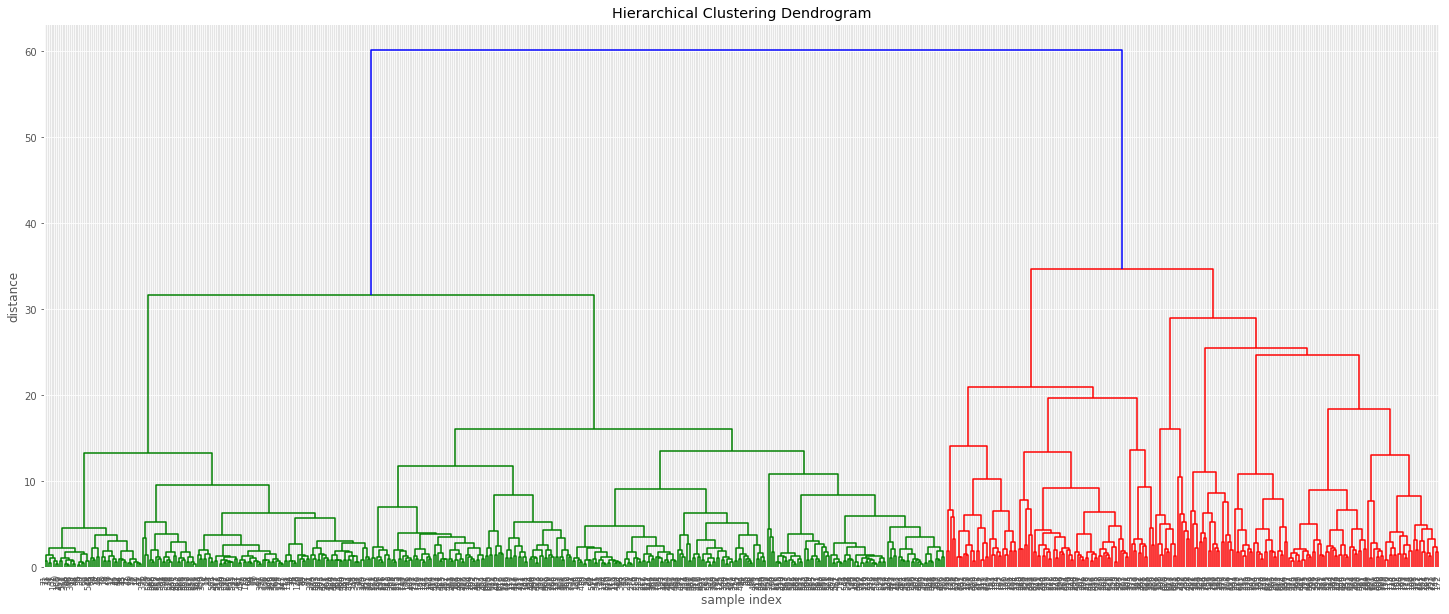

In [14]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

We have already seen the distances associated with the first twenty steps in the clustering process. Having viewed the complete dendrogram we now look at the final twenty steps in the clustering process. Note how the distances increase in value quite rapidly, especially over the final six/seven steps.

In [15]:
Z[-20:]

array([[1239.   , 1244.   ,   10.884,   25.   ],
       [1234.   , 1248.   ,   11.051,   20.   ],
       [1240.   , 1247.   ,   11.751,   92.   ],
       [1242.   , 1245.   ,   13.025,   33.   ],
       [1209.   , 1253.   ,   13.306,  150.   ],
       [1243.   , 1251.   ,   13.468,   51.   ],
       [1250.   , 1256.   ,   13.576,  171.   ],
       [ 395.   , 1252.   ,   13.595,   12.   ],
       [1236.   , 1254.   ,   14.077,   33.   ],
       [1228.   , 1255.   ,   16.088,   16.   ],
       [1259.   , 1263.   ,   16.088,  263.   ],
       [1249.   , 1260.   ,   18.473,   69.   ],
       [1262.   , 1264.   ,   19.662,   63.   ],
       [1265.   , 1269.   ,   21.016,   96.   ],
       [1257.   , 1268.   ,   24.744,   94.   ],
       [1258.   , 1271.   ,   25.547,  114.   ],
       [1266.   , 1272.   ,   29.018,  130.   ],
       [1261.   , 1267.   ,   31.626,  413.   ],
       [1270.   , 1273.   ,   34.671,  226.   ],
       [1274.   , 1275.   ,   60.181,  639.   ]])

Next, we can look at the dendrogram for the last twenty steps in the clustering process.

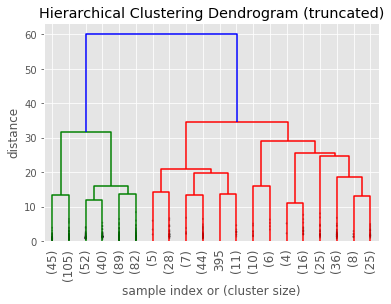

In [16]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

We can change the value of p to view just the last 10 steps in the process.

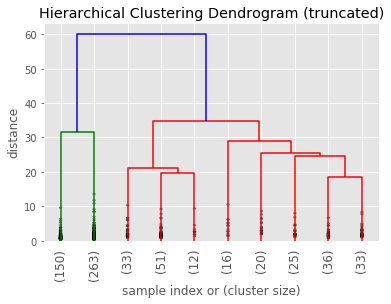

In [17]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

We can also look at a bar graph showing the distances associated with the final twenty steps in the clustering process

<Container object of 20 artists>

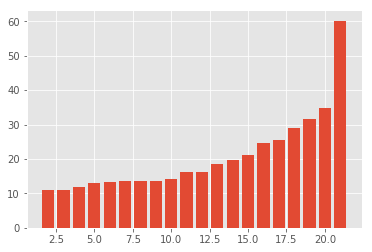

In [18]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(len(last) + 1, 1, -1)
plt.bar(idxs, last_rev)

I have to admit that I find the decision of how many clusters to choose a bit baffling. In this instance, we go for five clusters.

In [19]:
print (fcluster(Z, 5,criterion='maxclust'))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 2 1 1 1 1 1 2 1 1 1 2 2 1
 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 2 1 1 2 2 2 2 2 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 1 2 1 1 1 1 1 1 2 2 2 2 2 1 2 1 1 2 5 2 2 2 2 2 2 2
 1 1 5 5 2 1 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 5 2 2
 5 5 5 2 5 3 3 5 5 3 4 5 5 5 5 5 5 5 3 3 5 5 5 5 5 5 5 2 3 3 3 5 2 2 2 5 3
 5 5 5 5 3 3 3 3 3 3 3 3 5 3 1 3 3 5 5 5 2 3 3 5 3 3 2 2 2 2 2 2 2 2 2 5 5
 5 5 5 3 3 3 3 3 3 5 5 2 3 3 5 5 4 4 3 3 3 3 3 3 5 5 3 5 3 5 5 5 2 2 2 2 2
 2 3 3 3 3 3 2 2 2 5 2 2 2 2 2 2 3 3 3 3 3 5 5 5 5 5 2 2 2 2 3 3 3 3 5 2 5
 5 5 5 2 2 2 3 3 2 2 2 2 1 1 2 2 2 2 2 3 3 3 3 3 5 3 3 3 5 1 1 1 1 5 1 5 5
 5 5 1 5 5 1 1 1 1 1 1 2 1 1 3 3 3 3 2 2 2 2 5 1 1 4 2 2 1 1 2 2 2 2 2 1 1
 1 3 5 3 3 3 3 5 3 5 3 3 3 3 5 5 2 2 5 1 4 4 4 5 1 3 2 1 2 2 2 2 2 5 2 2 2
 2 3 2 2 2 2 2 1 3 2 5 2 2 2 2 2 2 2 5 2 2 4 2 2 2 4 3 5 3 5 5 3 2 2 5 5 1
 5 2 5 1 2 2 2 2 1 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 1 2 5 5 2 2 2 2 2
 5 2 2 2 1 2 5 5 5 5 2 1 

We create a new column, 'cluster' in the original DataFrame and then populate it with the values from our clustering analysis.

In [20]:
df_orig['cluster'] = (fcluster(Z, 5,criterion='maxclust'))

A quick look, this time at the last five rows in the DataFrame, and all appears to be good.

In [21]:
df_orig.tail()

,lsoa,imd_rank,imd_decile,indicator_group,estimated_pats_with_condition,All_ethnicities,White,Gypsy_traveller,Mixed_Ethnicity,Indian,...,Bangladeshi,Chinese,Other_Asian,Black_African_Caribbean,Other,group_desc,list_type,patients,ward_name,cluster
634,E01009382,3112,1,DEP,114.14,1836,130,0,25,153,...,53,10,156,73,70,Depression,18OV,2360,Springfield,3
635,E01009391,4583,2,DEP,101.84,1622,198,0,45,226,...,59,5,100,92,19,Depression,18OV,2371,Springfield,3
636,E01009392,6807,3,DEP,102.99,1774,203,0,37,214,...,79,6,126,44,60,Depression,18OV,2110,Springfield,3
637,E01009393,4120,2,DEP,97.00,1645,183,5,57,169,...,38,9,81,76,37,Depression,18OV,2279,Springfield,5
638,E01033641,4150,2,DEP,205.21,3296,460,0,101,309,...,145,13,188,185,96,Depression,18OV,4358,Springfield,3


We now have our original DataFrame clustered into five groups. [In the next step we will analyse the individual clusters.](http://localhost:8888/notebooks/Google%20Drive/qof/Birmingham%20Depression%20Clustering%20Analysis.ipynb)